# Imports and configuration

In [185]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import axes3d
from xgboost import XGBClassifier
from datetime import date
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA

# Will allow us to embed images in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 3)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

r = 666
np.random.seed(r)

# Loading original dataset

In [2]:
dataset = pd.read_csv("../common/dataset.csv", header=0, index_col='CUST_COD')
# Backup original dataset
orig_dataset = dataset.copy()

print(orig_dataset.shape)

(26884, 24)


In [3]:
orig_dataset.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,BIRTH_DATE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,...,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
CUST_COD,,,,,,,,,,,,,,,,,,,,,
53613503,1490.680,M,university,single,NaN,0,0,0,0,2,...,629.156401,599.283174,608.257067,89.440800,149.06800,68.571280,0.000000,29.81360,59.627200,0
35524089,5664.584,M,university,married,04/01/1983,0,0,0,0,0,...,533.872135,-2.772665,-14.399969,149.068000,159.83071,29.813600,0.000000,0.00000,0.000000,1
58777007,6260.856,F,high school,married,02/01/1975,0,0,-1,-1,-2,...,-19.349026,-19.349026,-19.349026,59.627200,532.59015,16.963938,0.000000,0.00000,29.813600,0
26913418,8944.080,F,graduate school,married,15/01/1977,-2,-2,-2,-2,-2,...,88.546392,70.330282,253.177091,80.556347,217.22189,88.784901,70.628418,298.46395,216.416922,0
41993633,3577.632,F,graduate school,married,09/01/1978,-1,-1,-1,-1,-1,...,0.000000,569.439760,0.000000,119.254400,29.81360,0.000000,569.439760,0.00000,0.000000,1


In [4]:
orig_dataset.describe()

,LIMIT_BAL,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,BILL_AMT_NOV,BILL_AMT_OCT,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
count,26884.00000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000
mean,4997.91411,-0.016367,-0.133313,-0.166344,-0.219052,-0.264879,-0.291884,1530.136656,1467.012379,1404.166272,1292.346498,1203.977907,1159.529034,168.639427,178.825861,156.416357,144.518815,144.259750,157.534344,0.221098
std,3879.73624,1.123991,1.197715,1.197837,1.171221,1.135089,1.150547,2206.111841,2129.923058,2072.220534,1923.241494,1816.137779,1775.876050,495.392694,688.001298,531.588567,465.903631,463.780141,538.637089,0.414994
min,298.13600,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-4936.535888,-2080.303567,-4688.605990,-2424.859342,-2424.859342,-10124.788000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1490.68000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,105.115300,87.622170,79.535231,68.951403,52.553923,37.594950,29.634718,24.879449,11.627304,8.884453,7.870790,3.637259,0.000000
50%,4173.90400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,667.198554,631.705464,599.491869,568.008707,539.998830,506.920641,62.608560,60.044590,54.260752,44.720400,44.720400,44.720400,0.000000
75%,7155.26400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1997.891324,1905.320095,1798.386166,1629.998953,1504.528417,1473.179417,149.276695,149.068000,134.369895,119.709057,120.379863,119.321481,0.000000
max,29813.60000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,28755.545150,29334.525260,49612.483810,26581.388370,27642.305330,28670.665830,26043.729910,50213.824120,26714.178140,18514.245600,12716.364990,15761.436660,1.000000


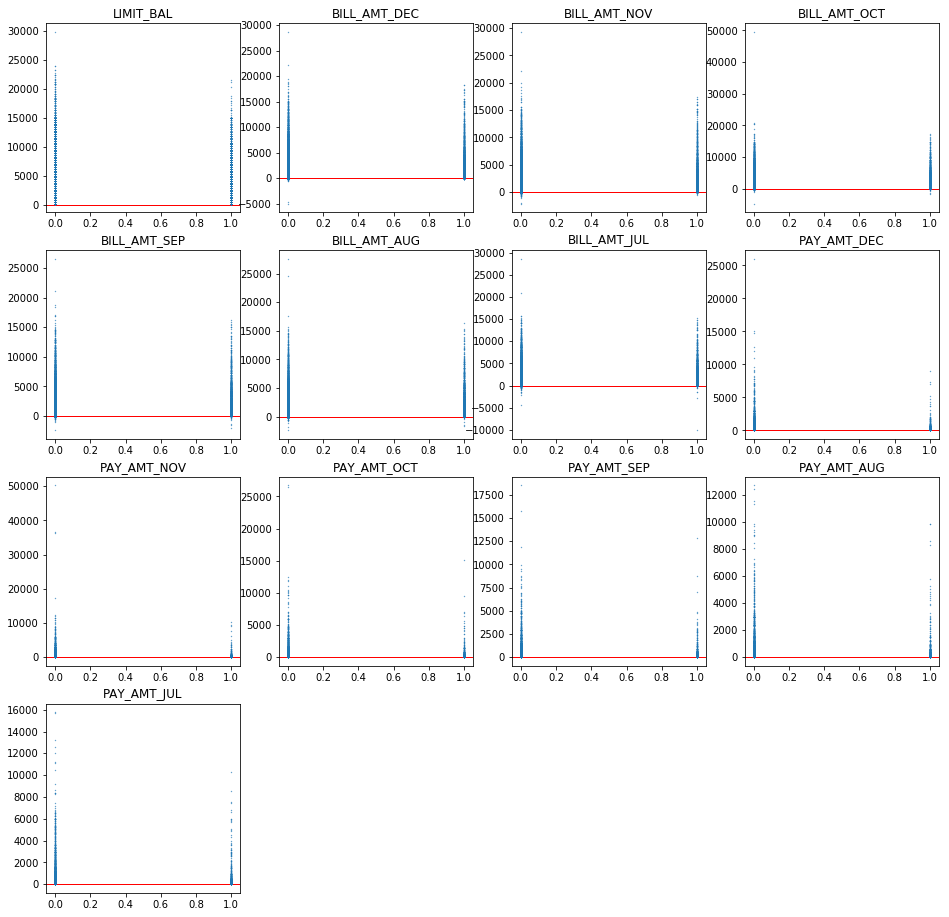

In [5]:
fig = plt.figure(figsize=(16, 4 * 4))
fields = ['LIMIT_BAL',
              'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']
# 13 fields
i = 1
for col_name in fields:
    ax = fig.add_subplot(4,4,i)
    i += 1
    ax.set_title(col_name)
    ax.scatter(orig_dataset['DEFAULT PAYMENT JAN'], orig_dataset[col_name], s=0.1)
    ax.axhline(y=0, c='red', linewidth=1, zorder=0)
plt.show() 

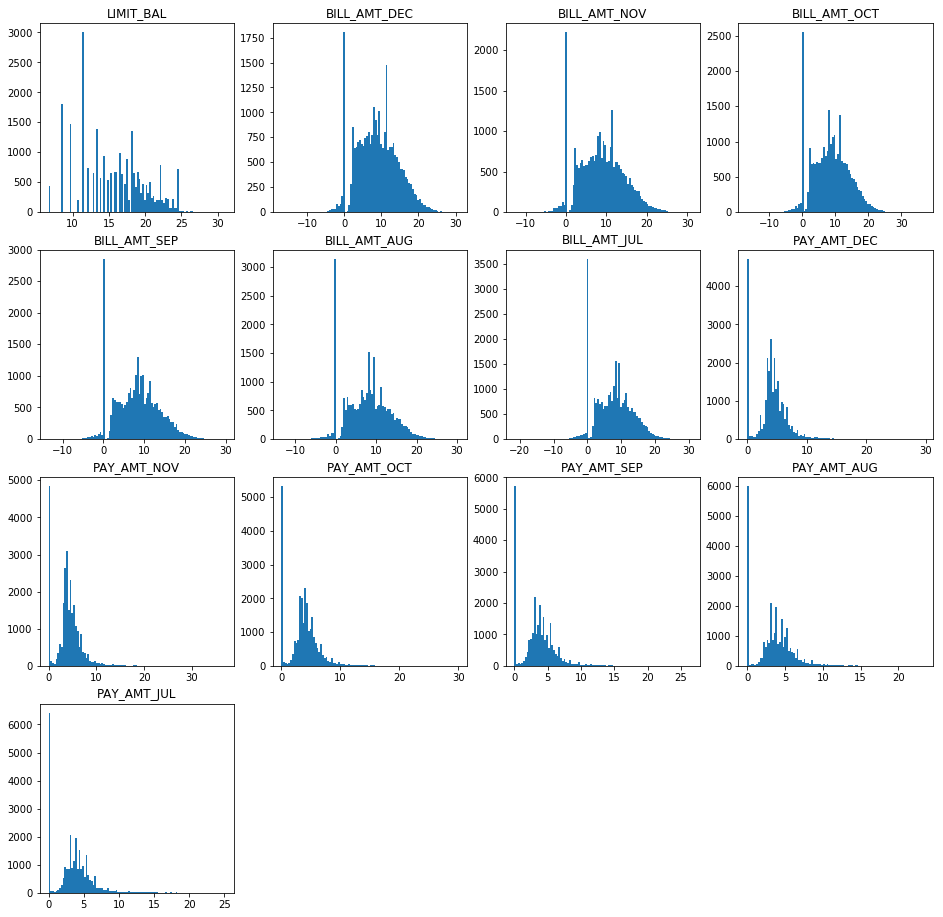

In [6]:
fig = plt.figure(figsize=(16, 4 * 4))
fields = ['LIMIT_BAL',
              'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']
# 13 fields
i = 1
for col_name in fields:
    ax = fig.add_subplot(4,4,i)
    i += 1
    # ax.set_ylabel('count')
    ax.set_title(col_name)
    ax.hist(np.cbrt(orig_dataset[col_name]), 100)
plt.show() 

In [8]:
print((orig_dataset['PAY_AMT_DEC'] < 100).sum())
print((orig_dataset['PAY_AMT_NOV'] == 0).sum())
print((orig_dataset['PAY_AMT_OCT'] == 0).sum())
print((orig_dataset['PAY_AMT_SEP'] == 0).sum())
print((orig_dataset['PAY_AMT_AUG'] == 0).sum())
print((orig_dataset['PAY_AMT_JUL'] == 0).sum())
print()
k = 1
print(((orig_dataset['PAY_AMT_DEC'] < k) &
       (orig_dataset['PAY_AMT_NOV'] < k) &
       (orig_dataset['PAY_AMT_OCT'] < k) &
       (orig_dataset['PAY_AMT_SEP'] < k) &
       (orig_dataset['PAY_AMT_AUG'] < k) &
       (orig_dataset['PAY_AMT_JUL'] < k) &
       (orig_dataset['DEFAULT PAYMENT JAN'] == 0) ).sum())
print(((orig_dataset['PAY_AMT_DEC'] < k) &
       (orig_dataset['PAY_AMT_NOV'] < k) &
       (orig_dataset['PAY_AMT_OCT'] < k) &
       (orig_dataset['PAY_AMT_SEP'] < k) &
       (orig_dataset['PAY_AMT_AUG'] < k) &
       (orig_dataset['PAY_AMT_JUL'] < k) &
       (orig_dataset['DEFAULT PAYMENT JAN'] == 1) ).sum())

16997
4835
5334
5732
5989
6418

805
496


               0     1
PAY_AUG_0  12307  2870
PAY_JUL_0  11834  2747
PAY_SEP_0  12022  2707
PAY_OCT_0  11624  2476
PAY_NOV_0  11825  2252


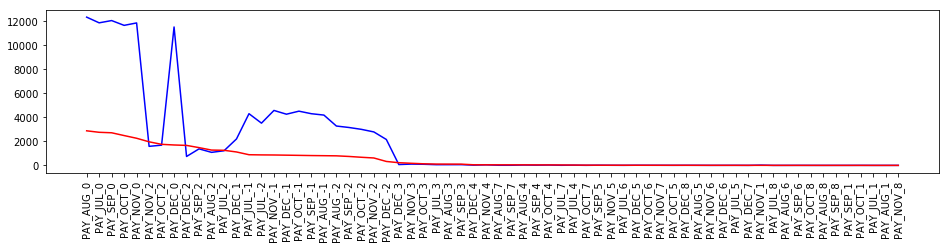

In [9]:
fields = ['PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
df = pd.DataFrame()
for field in fields:
    for j in [0]:
        for i in np.arange(-2,9):
            df['{}_{}'.format(field, i, j)] = (orig_dataset[field] == i) & (orig_dataset['DEFAULT PAYMENT JAN'] == j)
df1 = pd.DataFrame(df.sum())

df2 = pd.DataFrame()
for field in fields:
    for j in [1]:
        for i in np.arange(-2,9):
            df2['{}_{}'.format(field, i, j)] = (orig_dataset[field] == i) & (orig_dataset['DEFAULT PAYMENT JAN'] == j)
df3 = pd.DataFrame(df2.sum())
df3.rename(columns={0: 1}, inplace=True)

df4 = pd.concat([df1, df3], axis=1).sort_values([1], ascending = 0)
df4 = df4.sort_values([1], ascending = 0)

print(df4.head(5))
fig = plt.figure(figsize=(16, 3))
plt.plot(df4[0].tolist(), c='b')
plt.plot(df4[1].tolist(), c='r')
plt.xticks(np.arange(0, df4[0].size), df4.index, rotation='vertical')
plt.show()

# Different datasets management
- split_and_add
- add_dataset
- retrieve_dataset

In [181]:
# Format: {'name' : X_name}
X_dict = {}
# Format: {'name' : y_name}
y_dict = {}
# Format: {'name' : X_test_name}
X_test_dict = {}
# Format: {'name' : y_test_name}
y_test_dict = {}

names = set()
target_col_name = 'DEFAULT PAYMENT JAN'

def split_and_add(dataset, name):
    train, test = train_test_split(dataset, test_size=0.33, random_state=r, stratify=dataset[target_col_name])
    X = train.drop([target_col_name], 1)
    y = train[target_col_name]
    X_test = test.drop([target_col_name], 1)
    y_test = test[target_col_name]
    add_dataset(X, y, X_test, y_test, name)
    print('Train X shape: {}'.format(X.shape))
    print('Test X shape: {}'.format(X_test.shape))

def add_dataset(X, y, X_test, y_test, name):
    names.add(name)
    X_dict[name] = X
    y_dict[name] = y
    X_test_dict[name] = X_test
    y_test_dict[name] = y_test

def retrieve_dataset(name):
    return (X_dict[name], y_dict[name], X_test_dict[name], y_test_dict[name])

split_and_add(dataset=orig_dataset, name='orig')
split_and_add(dataset=orig_dataset.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'BIRTH_DATE'], 1), name='baseline')
X, y, X_test, y_test = retrieve_dataset('baseline')
rs = RobustScaler()
rs.fit(X)
X = pd.DataFrame(rs.transform(X), index = X.index, columns = X.columns)
X_test = pd.DataFrame(rs.transform(X_test), index = X_test.index, columns = X_test.columns)
add_dataset(X, y, X_test, y_test, 'baseline_scaled')

Train X shape: (18012, 23)
Test X shape: (8872, 23)
Train X shape: (18012, 19)
Test X shape: (8872, 19)


# Alessandro's dataset
- One hot encoding of SEX
- scores to MARRIAGE and EDUCATION
- BIRTH_DATE transformed to AGE and normalized
- Columns with money values like LIMIT_BAL and BILL_AMT_DEC normalized togheter to mean=0 std=1
- Delay in payments normalized togheter to mean=0 std=1

In [186]:
def transform_features(X_orig):
    X = X_orig.copy()
    # print('One hot encoding SEX feature')
    # set(dataset["SEX"]) = {nan, 'M', 'F'}
    fields = {'SEX'}
    for field in fields:
        X = pd.concat([X.drop([field], 1), pd.get_dummies(X[field])], axis=1)

    # print('Scoring EDUCATION and MARRIAGE features')
    # Assume other == Nan
    # set(dataset["EDUCATION"]) = {nan, 'high school', 'graduate school', 'other§', 'university'}
    # set(dataset["MARRIAGE"]) = {nan, 'other', 'single', 'married'}
    education_dict = { 'other': 0, 'high school': 0.1, 'university': 0.5, 'graduate school': 1}
    marriage_dict = {'other': 0, 'single': 0.1, 'married': 1}
    X['EDUCATION'] = X['EDUCATION'].fillna('other').apply(lambda x: education_dict[x])
    X['MARRIAGE'] = X['MARRIAGE'].fillna('other').apply(lambda x: marriage_dict[x])

    # print('Computing AGE and dropping BIRTH_DATE')
    X['BIRTH_DATE'] = pd.to_datetime(X['BIRTH_DATE'], format='%d/%m/%Y')
    def calculate_age(birth_date):
        today = date.today()
        age = today.year - birth_date.year
        full_year_passed = (today.month, today.day) < (birth_date.month, birth_date.day)
        if not full_year_passed:
            age -= 1
        return age
    X['AGE'] = X['BIRTH_DATE'].apply(lambda x: calculate_age(x))
    X = X.drop(["BIRTH_DATE"], 1)
    X['AGE'] = X['AGE'].fillna(X['AGE'].median())

    fields = ['LIMIT_BAL',
              'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']

    months = ['JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    
    for month in months:
        f = 'BILL_AMT_MINUS_PAY_AMT_{}'.format(month)
        X[f] = X['BILL_AMT_{}'.format(month)] - X['PAY_AMT_{}'.format(month)]
        fields.append(f)
        
        f = 'LIMIT_BAL_MINUS_BILL_AMT_{}'.format(month)
        X[f] = X['LIMIT_BAL'] - X['BILL_AMT_{}'.format(month)]
        fields.append(f)
        
        f = 'LIMIT_BAL_MINUS_PAY_AMT_{}'.format(month)
        X[f] = X['LIMIT_BAL'] - X['PAY_AMT_{}'.format(month)]
        fields.append(f)
        
        f = 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_{}'.format(month)
        X[f] = X['LIMIT_BAL'] - X['BILL_AMT_{}'.format(month)] + X['PAY_AMT_{}'.format(month)]
        fields.append(f)

    # print('Normalizing € fields')
    X[fields] = X[fields].apply(lambda x: np.cbrt(x))
    # np.cbrt is the only one that works with negative numbers
    # using pow with 1/3 or 1/5 etc with negative numbers leads to complex number as results because of
    # numerical approximations
    # np.cbrt instead apply the direct algorithm to find cubic root, which is well defined for every negative number

    fields = ['PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
    X[fields] = (X[fields] + 2) / 10

    min_age = X['AGE'].min()
    max_age = X['AGE'].max()
    X['AGE'] = X['AGE'].apply(lambda x: (x - min_age) / (max_age - min_age))
    X['AGE'] = np.sqrt(X['AGE'])
    
    # print('Dataset prepared')
    # print(X.shape)
    
    return X.copy()

X, y, X_test, y_test = retrieve_dataset(name='orig')
add_dataset(transform_features(X), y, transform_features(X_test), y_test, 'ale')
X, y, X_test, y_test = retrieve_dataset(name='ale')
X.head(5)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,LIMIT_BAL_MINUS_PAY_AMT_OCT,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT,BILL_AMT_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_NOV,LIMIT_BAL_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_NOV,BILL_AMT_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_DEC,LIMIT_BAL_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_DEC
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,13.360872,0.5,0.1,0.3,0.4,0.4,0.4,0.4,0.0,4.951950,...,13.359703,12.894522,-2.667993,13.142260,13.105506,13.396240,4.951950,13.130166,13.360872,13.130166
21308338,8.416822,1.0,0.1,0.2,0.2,0.2,0.2,0.2,0.2,7.777672,...,8.200910,3.956249,8.144970,-1.546246,8.126352,3.824275,6.850009,5.010426,7.647190,6.501787
54049646,17.507695,0.1,1.0,0.2,0.2,0.2,0.2,0.2,0.2,14.005143,...,17.404867,13.810163,13.766778,13.765100,17.343996,14.022601,13.805107,13.784845,17.380589,13.985457
10396398,9.634856,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,2.706525,...,9.634856,9.634856,0.000000,9.634856,9.634856,9.634856,2.706525,9.563132,9.634856,9.563132
11528589,14.857157,0.5,1.0,0.2,0.2,0.2,0.2,0.2,0.2,11.382419,...,14.720845,13.274978,10.365809,12.757330,14.720845,12.937948,11.146928,12.175198,14.720524,12.373542


In [187]:
X.describe().round(3)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,LIMIT_BAL_MINUS_PAY_AMT_OCT,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT,BILL_AMT_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_NOV,LIMIT_BAL_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_NOV,BILL_AMT_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_DEC,LIMIT_BAL_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_DEC
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,...,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,15.837,0.603,0.505,0.199,0.187,0.184,0.179,0.174,0.172,8.935,...,15.612,12.938,7.107,12.053,15.567,12.752,7.395,11.808,15.572,12.552
std,4.610,0.328,0.449,0.112,0.119,0.120,0.118,0.114,0.116,5.485,...,4.698,6.621,7.260,7.419,4.760,6.786,7.169,7.611,4.759,6.936
min,6.680,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-17.027,...,-10.058,-20.003,-28.119,-20.849,-27.754,-20.373,-27.141,-20.006,-18.283,-19.565
25%,11.423,0.500,0.100,0.100,0.100,0.100,0.100,0.100,0.100,4.830,...,11.423,8.179,2.181,6.908,11.423,7.664,2.901,6.484,11.423,7.362
50%,16.101,0.500,0.100,0.200,0.200,0.200,0.200,0.200,0.200,8.856,...,15.939,13.208,8.200,12.707,15.907,13.033,8.320,12.400,15.895,12.779
75%,19.270,1.000,1.000,0.200,0.200,0.200,0.200,0.200,0.200,12.646,...,19.015,18.143,12.137,18.079,18.998,18.140,12.343,18.016,18.998,18.133
max,28.172,1.000,1.000,1.000,0.900,1.000,0.900,0.900,1.000,28.133,...,28.139,29.263,27.838,28.051,28.143,33.453,27.873,28.053,28.087,30.909


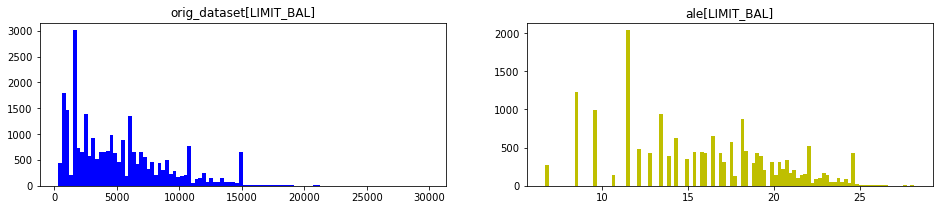

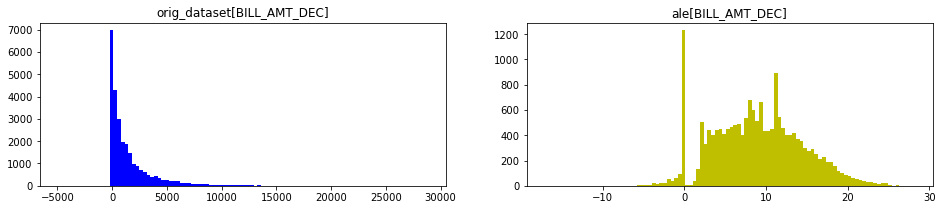

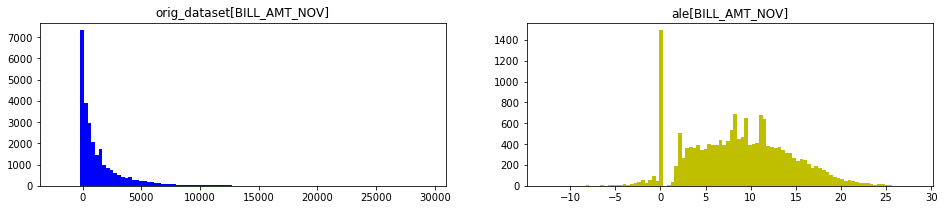

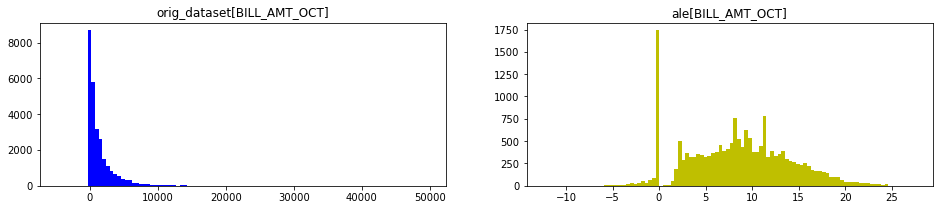

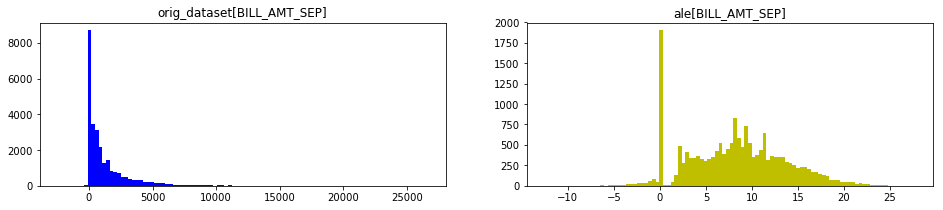

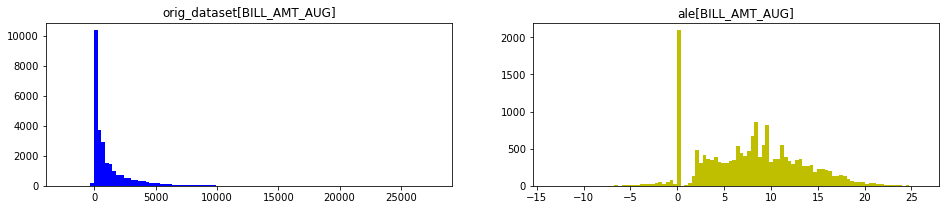

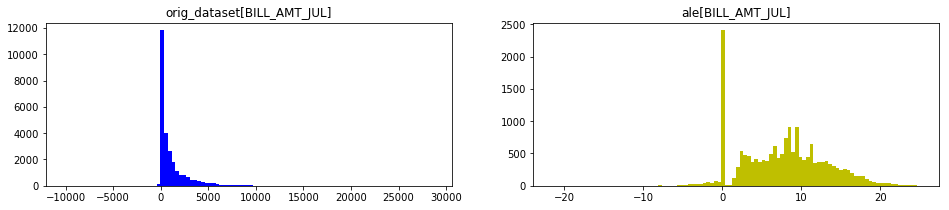

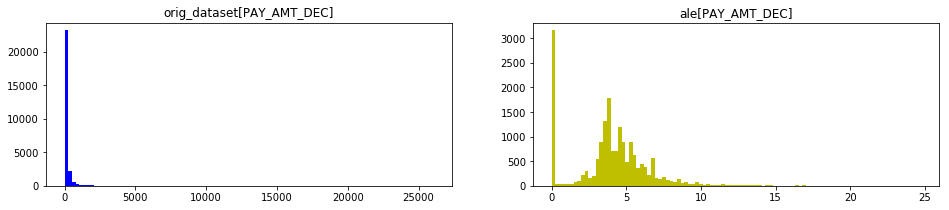

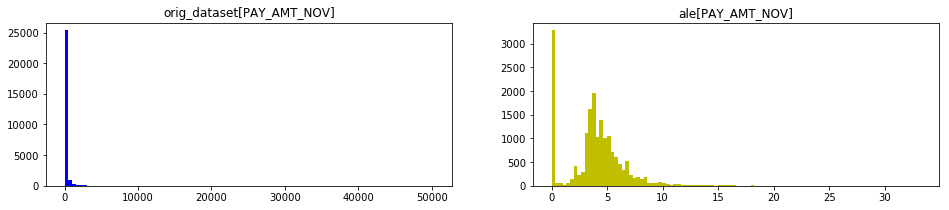

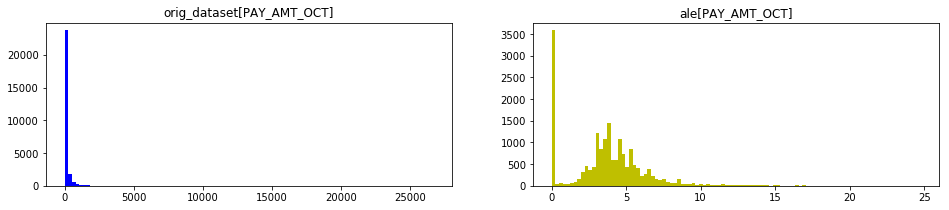

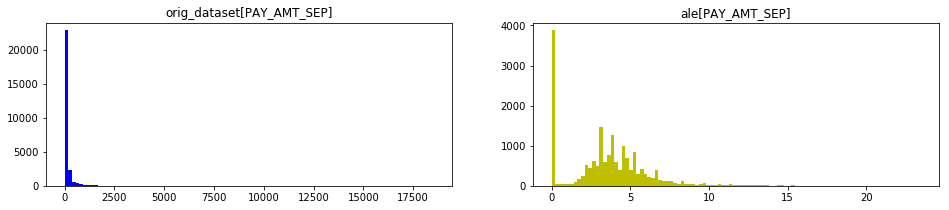

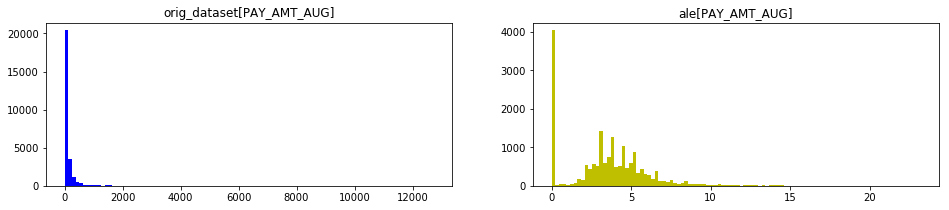

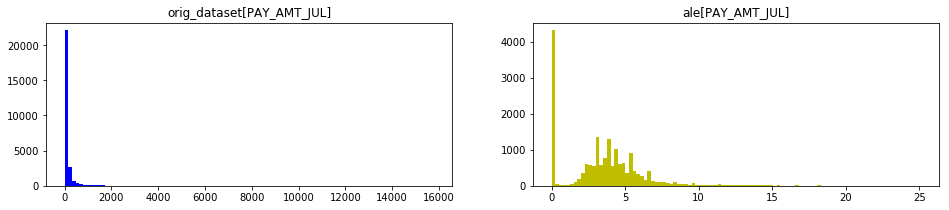

In [13]:
X, y, X_test, y_test = retrieve_dataset(name='ale')
fields = ['LIMIT_BAL',
          'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
          'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']
for col_name in fields:
    fig, axarr = plt.subplots(1, 2, figsize=(16, 3))
    axarr[0].hist(orig_dataset[col_name], 100, facecolor='b')
    # axarr[0].set_xlabel('Value')
    # axarr[0].set_ylabel('Density')
    axarr[0].set_title('orig_dataset[{}]'.format(col_name))

    axarr[1].hist(X[col_name], 100, facecolor='y')
    # axarr[1].set_xlabel('Value')
    # axarr[1].set_ylabel('Density')
    axarr[1].set_title('ale[{}]'.format(col_name))

    plt.show()

In [14]:
X.describe()

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,LIMIT_BAL_MINUS_PAY_AMT_OCT,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT,BILL_AMT_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_NOV,LIMIT_BAL_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_NOV,BILL_AMT_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_DEC,LIMIT_BAL_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_DEC
count,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,...,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000
mean,15.837318,0.603192,0.504536,0.199073,0.187081,0.183816,0.178853,0.174434,0.171502,8.934725,...,15.611654,12.937787,7.107439,12.053366,15.566588,12.752355,7.394664,11.808036,15.571764,12.552053
std,4.609824,0.328353,0.449097,0.112155,0.119147,0.119544,0.117635,0.114322,0.115776,5.484973,...,4.697995,6.621087,7.260240,7.418782,4.759589,6.785965,7.169477,7.611018,4.758717,6.936145
min,6.680436,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.027103,...,-10.058417,-20.002809,-28.118546,-20.848831,-27.754138,-20.373002,-27.140739,-20.006137,-18.283364,-19.564710
25%,11.423385,0.500000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,4.830134,...,11.423385,8.178685,2.180522,6.907764,11.423385,7.663596,2.900529,6.483691,11.423385,7.362027
50%,16.100801,0.500000,0.100000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,8.856074,...,15.938508,13.208269,8.200319,12.706631,15.906797,13.033011,8.319827,12.400130,15.895005,12.779214
75%,19.269712,1.000000,1.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,12.645696,...,19.015347,18.142540,12.137134,18.079202,18.998271,18.139588,12.342911,18.015701,18.998271,18.133493
max,28.172490,1.000000,1.000000,1.000000,0.900000,1.000000,0.900000,0.900000,1.000000,28.132541,...,28.138579,29.263447,27.838348,28.051076,28.143285,33.452874,27.872737,28.053033,28.086873,30.909333


# Dataset Creation - ale_scaled

In [188]:
X, y, X_test, y_test = retrieve_dataset('ale')
rs = RobustScaler()
rs.fit(X)
X_scaled = pd.DataFrame(rs.transform(X), columns=X.columns, index=X.index)
X_test_scaled = pd.DataFrame(rs.transform(X_test), columns=X_test.columns, index=X_test.index)
add_dataset(X_scaled, y, X_test_scaled, y_test, 'ale_scaled')
X_scaled.head(5)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,LIMIT_BAL_MINUS_PAY_AMT_OCT,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT,BILL_AMT_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_NOV,LIMIT_BAL_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_NOV,BILL_AMT_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_DEC,LIMIT_BAL_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_DEC
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,-0.349199,0.0,0.0,1.0,2.0,2.0,2.0,2.0,-2.0,-0.499532,...,-0.339676,-0.031488,-1.091567,0.038995,-0.369813,0.034673,-0.356677,0.063305,-0.334544,0.032582
21308338,-0.979309,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.137981,...,-1.019183,-0.928558,-0.005559,-1.275832,-1.027137,-0.879032,-0.155662,-0.640799,-1.088837,-0.582783
54049646,0.179306,-0.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.658823,...,0.193146,0.060408,0.559072,0.094748,0.189732,0.094463,0.580921,0.120076,0.196120,0.111985
10396398,-0.824073,-0.8,0.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-0.786834,...,-0.830306,-0.358638,-0.823605,-0.274967,-0.827991,-0.324375,-0.594479,-0.246011,-0.826435,-0.298574
11528589,-0.158500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323245,...,-0.160388,0.006695,0.217493,0.004538,-0.156564,-0.009074,0.299406,-0.019505,-0.155049,-0.037662


In [16]:
X_scaled.describe().round(3)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,LIMIT_BAL_MINUS_PAY_AMT_OCT,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT,BILL_AMT_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_NOV,LIMIT_BAL_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_NOV,BILL_AMT_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_DEC,LIMIT_BAL_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_DEC
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,...,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,-0.034,0.206,0.449,-0.009,-0.129,-0.162,-0.211,-0.256,-0.285,0.010,...,-0.043,-0.027,-0.110,-0.058,-0.045,-0.027,-0.098,-0.051,-0.043,-0.021
std,0.588,0.657,0.499,1.122,1.191,1.195,1.176,1.143,1.158,0.702,...,0.619,0.665,0.729,0.664,0.628,0.648,0.759,0.660,0.628,0.644
min,-1.201,-1.000,-0.111,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,-3.312,...,-3.424,-3.333,-3.648,-3.004,-5.764,-3.189,-3.755,-2.810,-4.512,-3.003
25%,-0.596,0.000,0.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-0.515,...,-0.595,-0.505,-0.605,-0.519,-0.592,-0.513,-0.574,-0.513,-0.590,-0.503
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.404,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.485,...,0.405,0.495,0.395,0.481,0.408,0.487,0.426,0.487,0.410,0.497
max,1.539,1.000,1.000,8.000,7.000,8.000,7.000,7.000,8.000,2.466,...,1.607,1.611,1.972,1.374,1.615,1.949,2.071,1.357,1.610,1.683


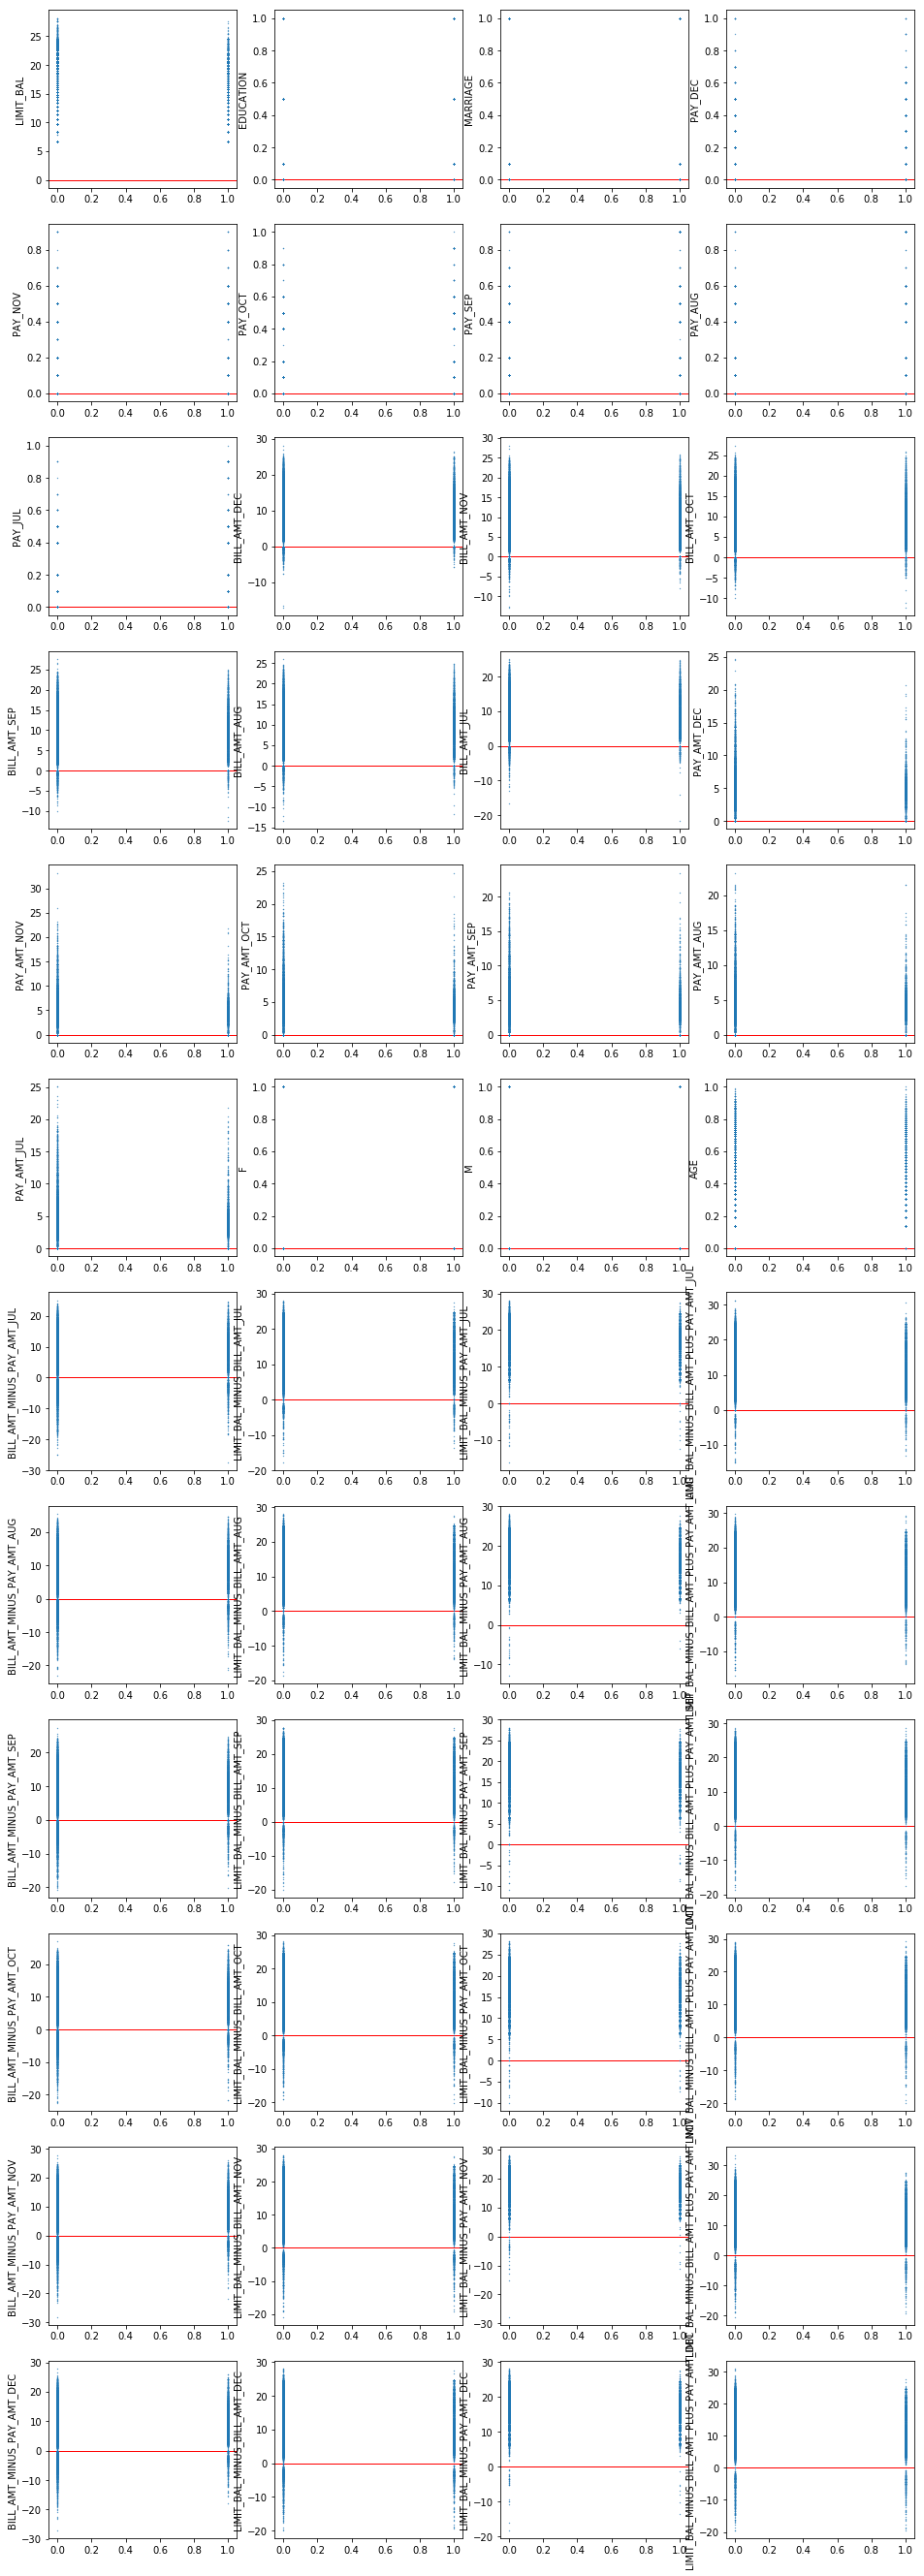

In [17]:
X, y, X_test, y_test = retrieve_dataset('ale')

i = 1
fig = plt.figure(figsize=(16, 12 * 4))
for col_name in X.columns:
    ax = fig.add_subplot(12, 4, i)
    i += 1
    ax.set_ylabel(col_name)
    ax.scatter(y, X[col_name], s=0.1)
    ax.axhline(y=0, c='red', linewidth=1, zorder=0)
plt.show() 

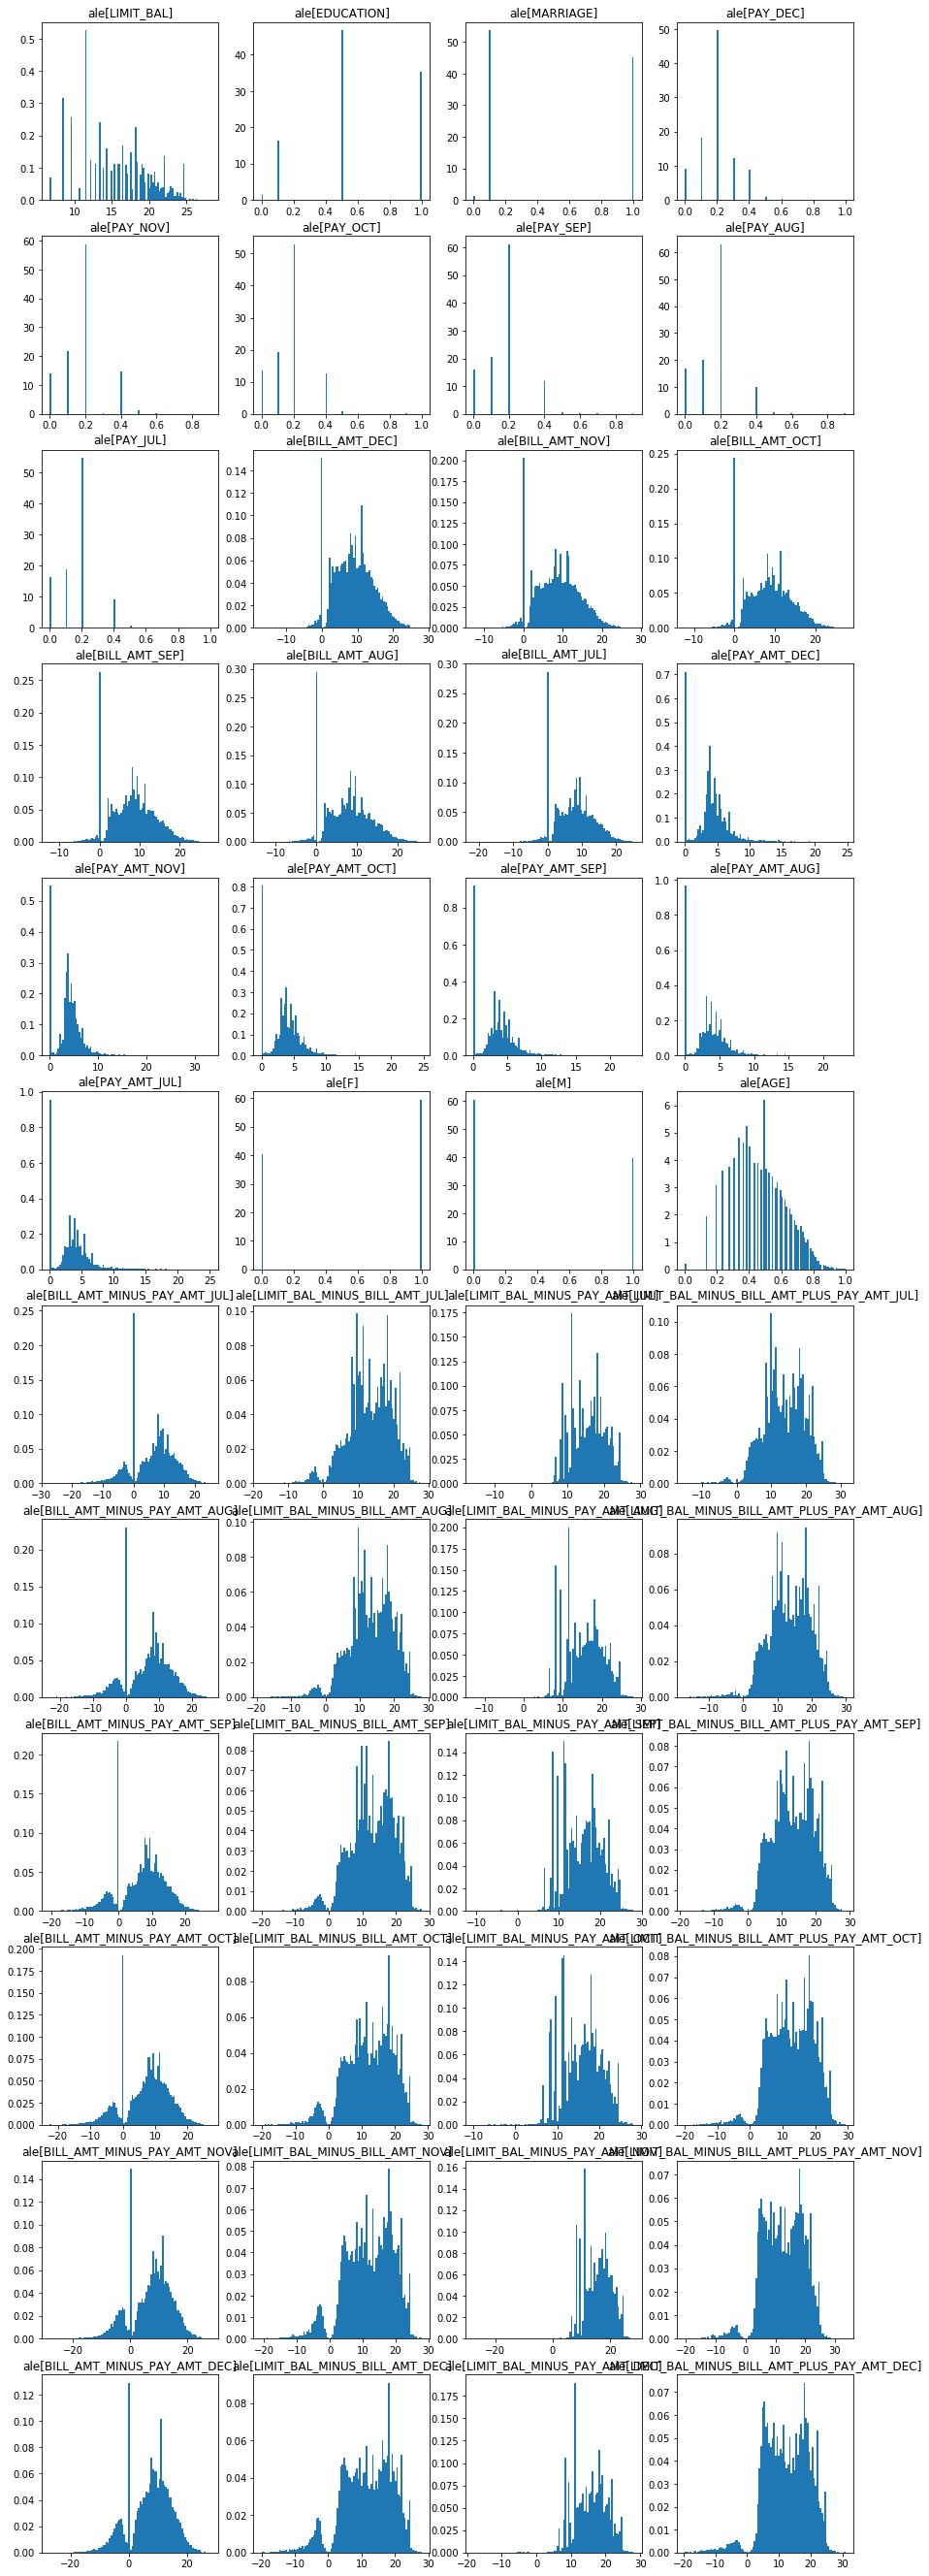

In [18]:
X, y, X_test, y_test = retrieve_dataset('ale')
fig = plt.figure(figsize=(15, 12 * 4))
i = 1
for col_name in X.columns:
    ax = fig.add_subplot(12, 4, i)
    i += 1
    ax.set_title('ale[{}]'.format(col_name))
    ax.hist(X[col_name], 100, normed=1)
plt.show()

# Preliminary Prediction Tests

In [19]:
X, y, X_test, y_test = retrieve_dataset(name='orig')

y_pred = X['PAY_AMT_DEC'] < X['BILL_AMT_DEC']
print(confusion_matrix(y, y_pred))
print(f1_score(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
print(confusion_matrix(y, y_pred))
print(f1_score(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
y_pred &= (X['PAY_AMT_DEC'] < X['BILL_AMT_DEC'] + 1000)
y_pred &= (X['PAY_AMT_NOV'] < X['BILL_AMT_NOV'] + 1000)
y_pred &= (X['PAY_AMT_OCT'] < X['BILL_AMT_OCT'] + 1000)
print(confusion_matrix(y, y_pred))
print(f1_score(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
y_pred &= (X['PAY_NOV'] > 0)
y_pred &= (X['PAY_OCT'] > 0)
print(confusion_matrix(y, y_pred))
print(f1_score(y, y_pred))

[[ 3109 10921]
 [  735  3247]]
0.357796143251
[[11985  2045]
 [ 1913  2069]]
0.511116600791
[[12057  1973]
 [ 1934  2048]]
0.511808071973
[[13432   598]
 [ 2931  1051]]
0.373290712129


# PAY_AMT vs Month, BILL_AMT vs Month

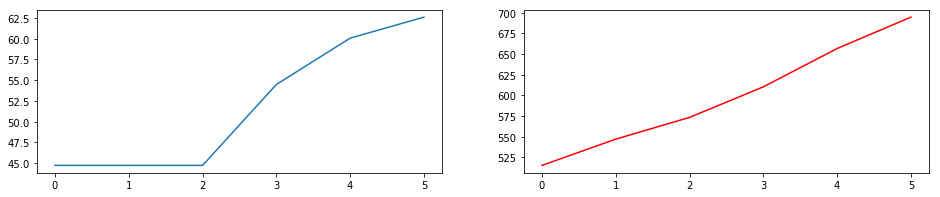

In [20]:
X, y, X_test, y_test = retrieve_dataset(name='orig')
months = ['JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

m = [X['PAY_AMT_{}'.format(month)].median() for month in months]

fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(1, 2, 1)
ax.plot(m)
m = [X['BILL_AMT_{}'.format(month)].median() for month in months]
ax = fig.add_subplot(1, 2, 2)
ax.plot(m, c='r')

plt.show()


# Variables distribution

# 2D PCA - ale_scaled

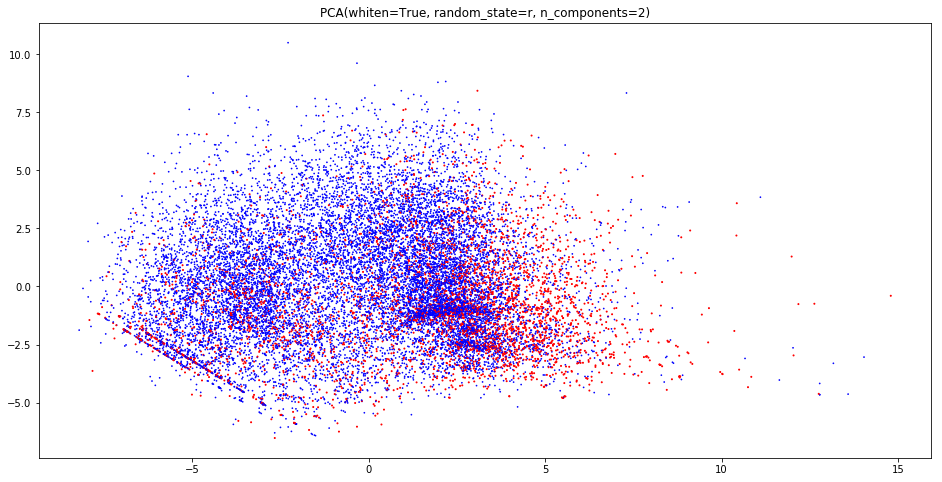

In [189]:
X, y, X_test, y_test = retrieve_dataset('ale_scaled')

colors = {0: 'b', 1: 'r', 2: 'y'}
sizes = {0: 0.5, 1: 1}

c = y.apply(lambda x: colors[x])
s = y.apply(lambda x: sizes[x])

pca = PCA(whiten=False, random_state=r, n_components=2)
pca.fit(X)

plt.figure(figsize=(16,8))
df = pd.DataFrame(pca.transform(X), index=X.index)
plt.scatter(df[0], df[1], c=c, s=s)
plt.title('PCA(whiten=True, random_state=r, n_components=2)')
plt.show()

# 3D PCA - ale_scaled

PCA(whiten=True, random_state=r, n_components=3)


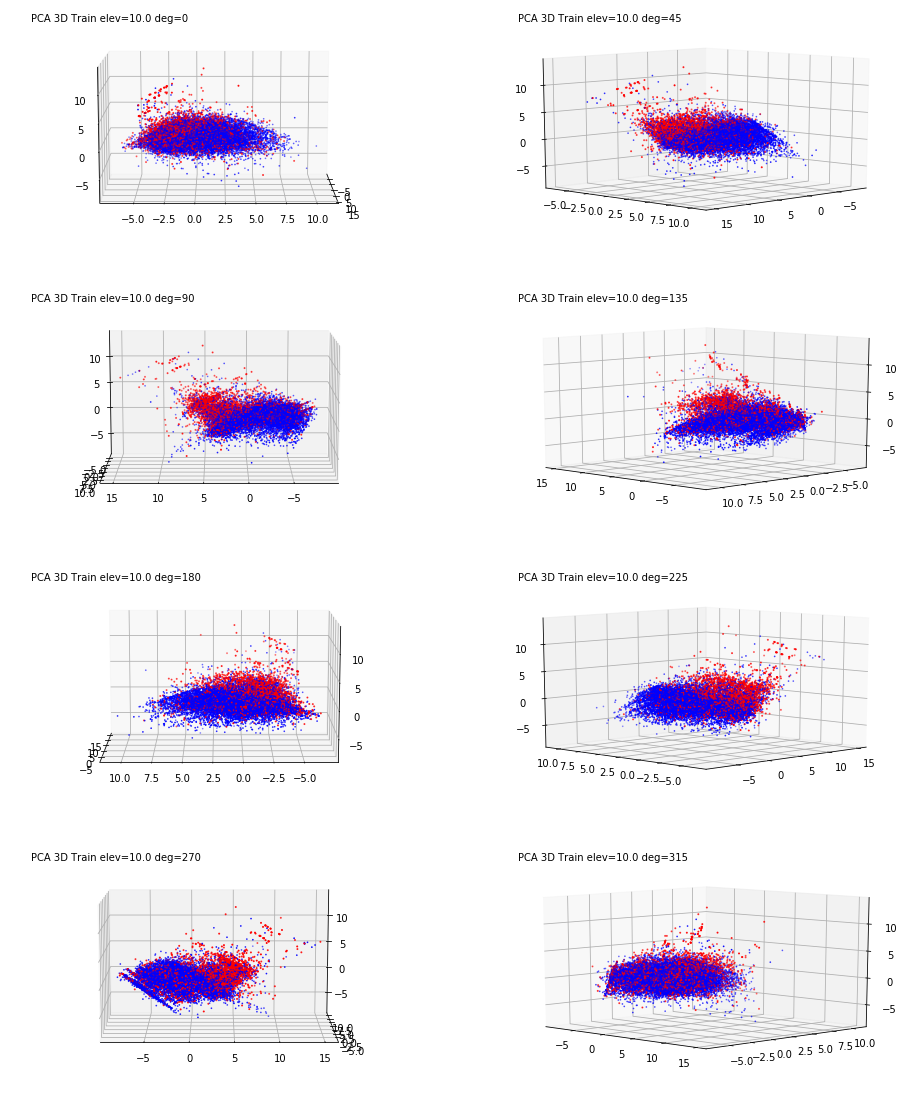

In [22]:
X, y, X_test, y_test = retrieve_dataset('ale_scaled')
colors = {0: 'b', 1: 'r', 2: 'y'}
sizes = {0: 0.5, 1: 1}
c = y.apply(lambda x: colors[x])
s = y.apply(lambda x: sizes[x])
         
print('PCA(whiten=True, random_state=r, n_components=3)')
pca = PCA(whiten=False, random_state=r, n_components=3)
pca.fit(X)
df = pd.DataFrame(pca.transform(X), index=X.index)
# kmeans = KMeans(n_clusters=5, random_state=r, copy_x=True, n_jobs=-1).fit(df)
# c = list(map(lambda x: 'C{}'.format(x), list(kmeans.predict(df))))
fig = plt.figure(figsize=(16, 6 * 5))
for ii in np.arange(0, 360, 45):
    ax = fig.add_subplot(6, 2, ii / 45 + 1, projection='3d')
    ax.text2D(0.05, 0.95, 'PCA 3D Train elev={} deg={}'.format(10., ii), transform=ax.transAxes)
    ax.view_init(elev=10., azim=ii)
    ax.scatter(df[0], df[1], df[2], c=c, s=s)
plt.show()

# PCA - tresh = 0.99

Starting PCA
cumsum_tresh = 0.8, n_components = 6
cumsum_tresh = 0.85, n_components = 9
cumsum_tresh = 0.9, n_components = 11
cumsum_tresh = 0.95, n_components = 16
cumsum_tresh = 0.97, n_components = 19
cumsum_tresh = 0.99, n_components = 25


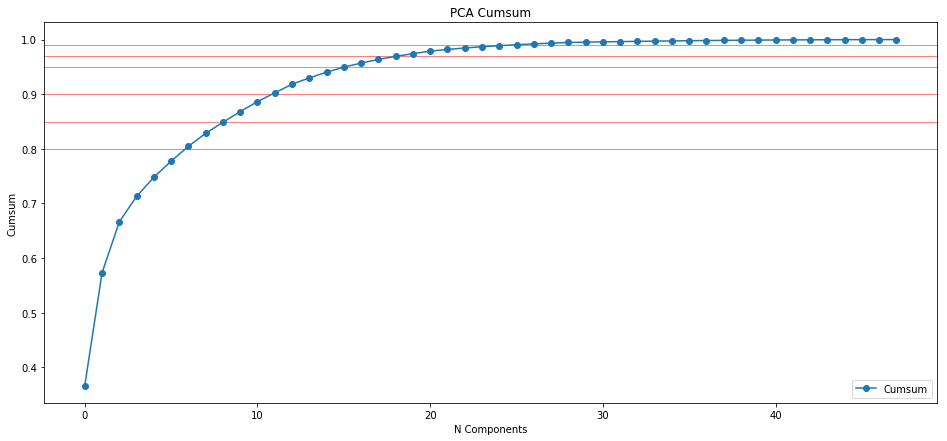

Selecting tresh = 0.99 -> n_components = 25


In [190]:
X, y, X_test, y_test = retrieve_dataset('ale_scaled')

print('Starting PCA')
pca = PCA(whiten=False, random_state=r)
pca.fit(X)

cumsum = sorted(list(pca.explained_variance_ratio_.cumsum()))

def find_cumsum_tresh(cumsum, cumsum_tresh):
    for i in np.arange(0, len(cumsum)):
        if cumsum[i] >= cumsum_tresh:
            break
    return i

plt.figure(figsize=(16, 7))
plt.plot(cumsum, label='Cumsum', marker='o')
plt.xlabel('N Components')
plt.ylabel('Cumsum')
plt.title('PCA Cumsum')
plt.legend(loc='best')

for i in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99]:
    n_components = find_cumsum_tresh(cumsum, i)
    print('cumsum_tresh = {}, n_components = {}'.format(i, n_components))
    plt.axhline(y=i, c='red', linewidth=0.5, zorder=0)

plt.show()

tresh = 0.99

n_components = find_cumsum_tresh(cumsum, tresh)
print('Selecting tresh = {} -> n_components = {}'.format(tresh, n_components))
pca = PCA(whiten=False, random_state=r, n_components=n_components)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X), index=X.index)
X_pca_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)

add_dataset(X_pca, y, X_pca_test, y_test, 'ale_pca')

In [24]:
X, y, X_test, y_test = retrieve_dataset('ale_pca')
X.head(5)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,1.390507,-2.581957,3.411576,0.547966,-0.500643,2.087851,-1.534219,-1.116858,0.282442,-0.485860,...,1.015224,-0.620057,0.793490,-0.056059,-1.274050,-0.188968,-0.017240,-0.119335,0.094532,0.539105
21308338,3.313220,-2.395449,-2.292633,0.875376,0.313818,-0.180872,0.205894,-0.002149,-0.028608,-1.535400,...,-0.296329,-0.181128,0.160981,0.172345,0.122286,-0.432031,0.208902,-0.103361,-0.104370,0.123448
54049646,1.039579,2.331435,-0.113116,-0.712580,-0.191056,0.116032,0.459902,0.356506,0.054872,1.101734,...,-0.291560,-0.393701,-0.284606,-0.089259,-0.081858,0.173685,0.041633,-0.020152,0.067762,0.096241
10396398,-2.536514,-5.351256,-1.883109,-1.131644,-0.299195,0.032044,0.439720,0.089159,0.137583,0.880304,...,-0.490336,-0.372074,0.102342,-0.992233,-0.065275,0.050822,0.069717,0.182756,-0.112781,0.015357
11528589,0.865359,0.844032,-0.140828,-0.001059,-0.113460,-0.179044,0.041155,0.019076,0.233891,0.759709,...,-0.147888,-0.427382,-0.398132,0.329124,0.018792,0.174552,-0.015171,0.043467,0.038648,0.029043


In [25]:
X.describe().round(3)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,...,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,...,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000
std,3.316,2.486,1.672,1.181,1.025,0.941,0.899,0.846,0.777,0.767,...,0.530,0.464,0.453,0.406,0.388,0.369,0.302,0.289,0.258,0.240
min,-8.206,-6.528,-7.601,-5.495,-6.320,-6.099,-4.748,-5.982,-4.651,-2.061,...,-2.732,-1.962,-2.628,-1.422,-2.346,-3.184,-2.278,-1.843,-1.810,-2.022
25%,-2.800,-1.832,-1.133,-0.776,-0.373,-0.383,-0.492,-0.312,-0.432,-0.605,...,-0.296,-0.308,-0.278,-0.260,-0.133,-0.161,-0.127,-0.133,-0.117,-0.100
50%,0.531,-0.313,-0.164,-0.067,-0.061,0.017,0.158,0.053,0.061,-0.024,...,-0.038,-0.049,-0.051,0.003,-0.016,0.052,-0.001,-0.013,0.000,0.007
75%,2.526,1.665,0.936,0.706,0.361,0.402,0.505,0.278,0.326,0.568,...,0.274,0.249,0.245,0.288,0.128,0.206,0.133,0.127,0.121,0.102
max,14.796,10.502,13.332,8.955,8.823,6.936,5.037,6.309,5.860,2.639,...,3.179,3.597,3.068,1.506,2.641,3.447,3.047,3.181,2.115,2.273


# CV and scoring functions

In [172]:
def score_matrix(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    # first index true
    # second index predicted
    return cm[0][0] * 1 + cm[0][1] * 0 + cm[1][0] * 0 + cm[1][1] * 4

def cv_clf(clf, X, y, y_pred, X_test, y_test, y_pred_test):
    scores_stkfold = cross_val_score(clf, X, y, scoring='f1', cv=cv)
    f1_cv_mean = scores_stkfold.mean()
    f1_cv_std = scores_stkfold.std()
    f1_train = f1_score(y, y_pred)  
    f1_test = f1_score(y_test, y_pred_test)
    print('f1_train = {:.3f}\t f1_cv = {:.3f} ± {:.3f}\nf1_test = {:.3f}'.format(f1_train, f1_cv_mean, f1_cv_std, f1_test))
    # cost_train = cost_matrix(y, y_pred)
    # cost_test = cost_matrix(y_test, y_pred_test)
    # print('cost_train = {}\ncost_test = {}'.format(format(cost_train, ','), format(cost_test, ',')))
    cm_train = confusion_matrix(y, y_pred)
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('cm_train = \n{}\ncm_test = \n{}'.format(cm_train, cm_test))

def fit_and_score(clf, name):
    print('Evaluating on ' + name + ' dataset')
    X, y, X_test, y_test = retrieve_dataset(name)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    y_pred_test = clf.predict(X_test)
    cv_clf(clf, X, y, y_pred, X_test, y_test, y_pred_test)
    if (hasattr(clf, 'predict_proba')):
        return (pd.DataFrame(clf.predict_proba(X), index = X.index)[1], 
                pd.DataFrame(clf.predict_proba(X_test), index = X_test.index)[1])
    else:
        return (y_pred, y_pred_test)

cv = StratifiedKFold(n_splits=10, random_state=r, shuffle=True)    
ms = make_scorer(score_matrix, greater_is_better=True)

# ROC curve function

In [27]:
def plot_roc_curve(clf, X_test, y_test):
    y_score = clf.decision_function(X_test)
    # Compute ROC curve and ROC area for each class
    fpr, tpr, t = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    t_sigm = 1 / (1 + np.exp(-t))

    i = sum(t < 0.5 for t in t_sigm)
    
    plt.figure(figsize=(16,7))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(fpr[i], tpr[i], 'ro')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Grid Search CV function

In [28]:
def grid_search_cv(parameters, clf, n_folds=5, dataset_name='ale', scoring='f1'):
    cv=StratifiedKFold(n_splits=5, random_state=r, shuffle=True)
    n_jobs = -1
    if scoring == ms:
        n_jobs = 1
    gscv = GridSearchCV(estimator=clf, param_grid=parameters, n_jobs=n_jobs, cv=cv, scoring=scoring)
    X, y, X_test, y_test = retrieve_dataset(dataset_name)
    gscv.fit(X, y)
    print('GridSearchCV done on: ' + dataset_name)
    print(gscv.best_params_)
    if scoring == ms:
            scoring = 'score'
    print(scoring + ' = ' + str(gscv.best_score_))
    if len(parameters) == 1:
        plt.figure(1)
        param_name = list(parameters.keys())[0]
        if param_name == 'C':
            plt.semilogx(parameters[param_name], gscv.cv_results_['mean_test_score'], label=scoring, marker='o')
        else:
            plt.plot(parameters[param_name], gscv.cv_results_['mean_test_score'], label=scoring, marker='o')
        plt.xlabel(param_name)
        plt.ylabel(scoring)
        plt.title('CV ' + scoring)
        plt.legend(loc='best')
        plt.show()

# Level 1 algorithms - Learning from features

In [173]:
X, y, X_test, y_test = retrieve_dataset('orig')
X_meta = pd.DataFrame(index=X.index)
X_meta_test = pd.DataFrame(index=X_test.index)

# Level 1 - Dummy Classifier
- All datasets: f1_cv = 0.217 ± 0.018

In [174]:
clf = DummyClassifier(random_state=r)
y_pred, y_pred_test = fit_and_score(clf, 'baseline')

Evaluating on baseline dataset
f1_train = 0.221	 f1_cv = 0.217 ± 0.018
f1_test = 0.225
cm_train = 
[[10932  3098]
 [ 3104   878]]
cm_test = 
[[5369 1541]
 [1519  443]]


# Level 1 - Linear Support Vector Classifier
- baseline: f1_cv = 0.522 ± 0.023

In [175]:
clf = LinearSVC(penalty='l2',
                loss='squared_hinge',
                dual=False,
                tol=1e-4,
                C=1,
                fit_intercept=True,
                intercept_scaling=0.001,
                class_weight='balanced',
                verbose=1000,
                random_state=r,
                max_iter=1000
               )
y_pred, y_pred_test = fit_and_score(clf, 'baseline')
X_meta['LSVC_baseline'] = y_pred
X_meta_test['LSVC_baseline'] = y_pred_test

Evaluating on baseline dataset
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]f1_train = 0.522	 f1_cv = 0.522 ± 0.023
f1_test = 0.514
cm_train = 
[[11758  2272]
 [ 1776  2206]]
cm_test = 
[[5796 1114]
 [ 897 1065]]


# Level 1 - TOO SLOW, OVERFITS Level 2 - Support Vector Classifier
- ale_pca: f1_cv = 0.351 ± 0.026

In [32]:
if False:
    clf = SVC(random_state=r, C=1, class_weight='balanced')
    y_pred, y_pred_test = fit_and_score(clf, 'ale_pca')
    X_meta['SVC_ale_pca'] = y_pred
    X_meta_test['SVC_ale_pca'] = y_pred_test

# Level 1 - Decision Tree Classifier
- baseline: f1_cv = 0.533 ± 0.021

In [176]:
clf = DecisionTreeClassifier(random_state=r, max_depth=4, class_weight='balanced')
# grid_search_cv(parameters={'max_depth': np.arange(1,10)}, clf=clf, scoring='f1', dataset_name='baseline')
y_pred, y_pred_test = fit_and_score(clf, 'baseline')
X_meta['DTC_baseline'] = y_pred
X_meta_test['DTC_baseline'] = y_pred_test

Evaluating on baseline dataset
f1_train = 0.534	 f1_cv = 0.533 ± 0.021
f1_test = 0.527
cm_train = 
[[11562  2468]
 [ 1631  2351]]
cm_test = 
[[5701 1209]
 [ 828 1134]]
CUST_COD
14356766    0.671707
21308338    0.368067
54049646    0.255764
10396398    0.450524
11528589    0.255764
20362183    0.255764
45569593    0.450524
44429180    0.368067
52612111    0.450524
34291217    0.255764
22484587    0.450524
52913781    0.255764
59230034    0.629293
13175350    0.368067
12582570    0.368067
51594012    0.255764
35571106    0.671707
16001040    0.255764
57296369    0.450524
35902487    0.255764
33070856    0.450524
33183607    0.450524
34849977    0.255764
16490032    0.927559
58011273    0.450524
45734499    0.255764
56990048    0.255764
47504826    0.871406
30633355    0.871406
38597549    0.368067
              ...   
40819584    0.450524
26731760    0.450524
47394107    0.368067
46272483    0.671707
40137864    0.255764
57671329    0.255764
41089924    0.255764
19657950    0.699723
1926

# Level 1 - Gaussian Naive Bayes
- baseline: f1_cv = 0.521 ± 0.014

In [177]:
# No random_state
# The priors are set based on class distribution in the dataset
# No CV needed
clf = GaussianNB()
y_meta, y_meta_test = fit_and_score(clf, 'baseline')
X_meta['GNB_baseline'] = y_meta
X_meta_test['GNB_baseline'] = y_meta_test

Evaluating on baseline dataset
f1_train = 0.521	 f1_cv = 0.521 ± 0.014
f1_test = 0.528
cm_train = 
[[11529  2501]
 [ 1700  2282]]
cm_test = 
[[5687 1223]
 [ 821 1141]]


# Level 1 - Random Forest Classifier
- baseline: f1_cv = 0.533 ± 0.026

In [178]:
clf = RandomForestClassifier(random_state=r,
                             #n_estimators=50,
                             class_weight='balanced',
                             max_depth=3,
                             n_jobs=-1,
                             #bootstrap=False
                            )
# TOO SLOW
# grid_search_cv(parameters={'n_estimators': [100, 250, 500, 1000, 2000]}, n_folds=3, clf=clf, scoring='f1', dataset_name='ale')
y_meta, y_meta_pred = fit_and_score(clf, 'baseline')
X_meta['RFC_baseline'] = y_meta
X_meta_test['RFC_baseline'] = y_meta_pred

Evaluating on baseline dataset
f1_train = 0.535	 f1_cv = 0.533 ± 0.026
f1_test = 0.530
cm_train = 
[[11726  2304]
 [ 1686  2296]]
cm_test = 
[[5814 1096]
 [ 860 1102]]


# Level 1 - OVERFITS Level 2 - K Neighbors Classifier
- baseline_scaled: f1_cv = 0.442 ± 0.024

In [179]:
if False:
    clf = KNeighborsClassifier(n_neighbors=5,
                           weights='uniform',
                           algorithm='auto',
                           leaf_size=30,
                           p=2,
                           metric='minkowski',
                           metric_params=None,
                           n_jobs=-1
                          )
    #grid_search_cv(parameters={'n_neighbors': np.arange(1,5), 'algorithm': ['ball_tree', 'kd_tree']}, clf=clf, scoring='f1', dataset_name='ale_pca')
    y_meta, y_meta_test = fit_and_score(clf, 'baseline_scaled')
    X_meta['KNNC_baseline_scaled'] = y_meta
    X_meta_test['KNNC_baseline_scaled'] = y_meta_test

# Level 1 - Multi Layer Perceptron Classifier
- ale: f1_cv = 0.525 ± 0.025 (24,12,8,4,2)

In [182]:
clf = MLPClassifier(hidden_layer_sizes=(24,12,8,4,2),
                    solver='adam',
                    activation='logistic',
                    batch_size=500,
                    # validation_fraction=0.5,
                    random_state=r,
                    verbose=False
                   )
y_meta, y_meta_test = fit_and_score(clf, 'baseline_scaled')
X_meta['MLPC_baseline_scaled'] = y_meta
X_meta_test['MLPC_baseline_scaled'] = y_meta_test

Evaluating on baseline_scaled dataset
f1_train = 0.529	 f1_cv = 0.525 ± 0.025
f1_test = 0.523
cm_train = 
[[12625  1405]
 [ 2044  1938]]
cm_test = 
[[6217  693]
 [1021  941]]


# Level 1 - Logistic Regression
- ale_pca: f1_cv = 0.511 ± 0.018

In [191]:
clf = LogisticRegression(penalty='l2', C=0.1, class_weight='balanced', fit_intercept=True, random_state=r, n_jobs=-1)
# grid_search_cv(parameters={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]}, clf=clf, scoring='f1', dataset_name='ale_pca')
y_meta, y_meta_test = fit_and_score(clf, 'ale_pca')
X_meta['LR_ale_pca'] = y_meta
X_meta_test['LR_ale_pca'] = y_meta_test

Evaluating on ale_pca dataset
f1_train = 0.512	 f1_cv = 0.511 ± 0.018
f1_test = 0.512
cm_train = 
[[10610  3420]
 [ 1433  2549]]
cm_test = 
[[5238 1672]
 [ 710 1252]]


[[ 0.16409311 -0.21113296  0.33899702 -0.14462624 -0.03781295 -0.00889638
  -0.08920803 -0.03856421 -0.10840407  0.09443061  0.24628034  0.15169241
   0.2299138   0.25155355  0.02056112  0.03236564  0.31687895  0.25966815
   0.15342993  0.02190827 -0.02100892 -0.11651955 -0.03092676 -0.09354693
  -0.06003282]]


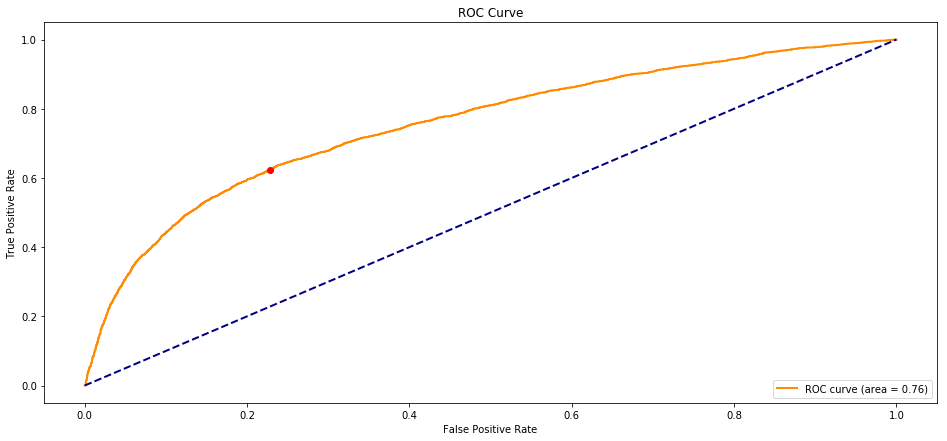

In [192]:
X, y, X_test, y_test = retrieve_dataset('ale_pca')
clf.fit(X, y)
print(clf.coef_)
plot_roc_curve(clf, X, y)
# plot_roc_curve(clf, X_test, y_test)
# t = 0.53
# y_pred = pd.DataFrame(clf.predict_proba(X))[1] > t # p0 p1
# y_pred_test = pd.DataFrame(clf.predict_proba(X_test))[1] > t # p0 p1
# f1_train = f1_score(y, y_pred)  
# f1_test = f1_score(y_test, y_pred_test)
# print('f1_train = {:.3f}\nf1_test = {:.3f}'.format(f1_train, f1_test))
# cm_train = confusion_matrix(y, y_pred)
# cm_test = confusion_matrix(y_test, y_pred_test)
# print('cm_train = \n{}\ncm_test = \n{}'.format(cm_train, cm_test))

# Level 1 - XGBClassifier
- ale: f1_cv = 0.548 ± 0.021

In [193]:
# clf = XGBClassifier(seed=r, scale_pos_weight=3,
#                     learning_rate=0.1, n_estimators=100, 
#                     max_depth=3, min_child_weight=1,
#                     gamma=0.2, colsample_bytree=0.8, subsample=0.6)
clf = XGBClassifier(seed=r,
                    scale_pos_weight=3,
                    learning_rate=0.1
                   )
# grid_search_cv(parameters={'colsample_bytree':[0.2,0.5,0.8]}, clf=clf, scoring='f1', dataset_name='baseline')
y_meta, y_meta_test = fit_and_score(clf, 'ale')

X_meta['XGB_ale'] = y_meta
X_meta_test['XGB_ale'] = y_meta_test

Evaluating on ale dataset
f1_train = 0.572	 f1_cv = 0.548 ± 0.021
f1_test = 0.541
cm_train = 
[[11957  2073]
 [ 1554  2428]]
cm_test = 
[[5831 1079]
 [ 834 1128]]


# Level 1 - MEMORY ERROR, Gaussian Process Classifier

In [194]:
if False:
    clf = GaussianProcessClassifier(kernel=None,
                                optimizer='fmin_l_bfgs_b',
                                n_restarts_optimizer=0, 
                                max_iter_predict=100,
                                warm_start=False,
                                copy_X_train=True,
                                random_state=r,
                                #multi_class='one_vs_rest',
                                n_jobs=-1)
    y_meta, y_meta_test = fit_and_score(clf, 'baseline')
    X_meta['GPC_baseline'] = y_meta
    X_meta_test['GPC_baseline'] = y_meta_test

# Level 1 - Linear Discriminant Analysis

In [195]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis(solver='svd', shrinkage=None, priors=[0.5, 0.5], 
                                 n_components=None, store_covariance=False, tol=0.0001)
y_meta, y_meta_test = fit_and_score(clf, 'ale')
X_meta['LDA_ale'] = y_meta
X_meta_test['LDA_ale'] = y_meta_test

Evaluating on ale dataset
f1_train = 0.518	 f1_cv = 0.516 ± 0.023
f1_test = 0.518
cm_train = 
[[11210  2820]
 [ 1602  2380]]
cm_test = 
[[5520 1390]
 [ 789 1173]]


# Level 1 - Quadratic Discriminant Analysis

In [196]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis(priors=[0.78, 0.22], reg_param=0.1, store_covariances=False, tol=0.0001)
y_meta, y_meta_test = fit_and_score(clf, 'ale_scaled')
X_meta['QDA_ale'] = y_meta
X_meta_test['QDA_ale'] = y_meta_test

Evaluating on ale_scaled dataset
f1_train = 0.522	 f1_cv = 0.517 ± 0.016
f1_test = 0.522
cm_train = 
[[11607  2423]
 [ 1718  2264]]
cm_test = 
[[5734 1176]
 [ 854 1108]]


# Build meta dataset for Level 2

In [197]:
X, y, X_test, y_test = retrieve_dataset('orig')
add_dataset(X_meta, y, X_meta_test, y_test, 'meta')
X, y, X_test, y_test = retrieve_dataset('meta')
X.head(20)

,LSVC_baseline,DTC_baseline,GNB_baseline,RFC_baseline,MLPC_baseline_scaled,LR_ale_pca,XGB_ale,LDA_ale,QDA_ale
CUST_COD,,,,,,,,,
14356766,1,0.671707,0.999679,0.799192,0.531713,0.766419,0.762332,0.838671,0.993918
21308338,0,0.368067,0.303871,0.380873,0.138216,0.478124,0.345209,0.424412,0.163653
54049646,0,0.255764,0.197041,0.309805,0.137572,0.323444,0.167023,0.303743,0.051994
10396398,0,0.450524,0.337151,0.458375,0.137482,0.418264,0.494664,0.344411,0.177240
11528589,0,0.255764,0.256009,0.309805,0.137556,0.386503,0.226437,0.335240,0.080753
20362183,0,0.255764,0.201743,0.336146,0.137600,0.502959,0.281292,0.488676,0.019019
45569593,0,0.450524,0.292875,0.384868,0.138336,0.484353,0.331808,0.451312,0.097287
44429180,0,0.368067,0.293873,0.367379,0.138090,0.449643,0.346615,0.408530,0.105179
52612111,0,0.450524,0.218550,0.458375,0.137482,0.307277,0.452048,0.244960,0.083085


In [198]:
X_test.head(20)

,LSVC_baseline,DTC_baseline,GNB_baseline,RFC_baseline,MLPC_baseline_scaled,LR_ale_pca,XGB_ale,LDA_ale,QDA_ale
CUST_COD,,,,,,,,,
12458332,0,0.255764,0.049655,0.367379,0.137496,0.321978,0.128160,0.289628,0.035092
53337233,0,0.255764,0.225982,0.323058,0.137582,0.381990,0.351961,0.375524,0.129373
13908353,0,0.450524,0.111171,0.368741,0.137482,0.215483,0.309958,0.144165,0.051602
50734226,0,0.255764,0.001459,0.338160,0.137484,0.204940,0.124140,0.185089,0.010004
58776367,0,0.450524,0.138561,0.384868,0.137534,0.536595,0.341364,0.551737,0.095162
57457139,0,0.368067,0.306756,0.335905,0.138156,0.590986,0.289925,0.441009,0.158889
11574451,0,0.255764,0.101379,0.309805,0.137495,0.254484,0.323076,0.211854,0.048498
31627502,0,0.450524,0.031722,0.368495,0.137482,0.263093,0.178927,0.207380,0.018647
48408936,0,0.255764,0.245131,0.367379,0.137503,0.402347,0.269328,0.362713,0.070995


# Learning from predictions - Level 2 algorithms

# Level 2 - ExtraTreesClassifier
- f1_cv = f1_cv = 0.572 ± 0.021
- f1_test = 0.542

In [199]:
clf = ExtraTreesClassifier(n_estimators=100,
                           criterion='gini',
                           max_depth=4,
                           min_samples_split=2,
                           min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0,
                           max_features='auto',
                           max_leaf_nodes=None,
                           min_impurity_split=1e-07,
                           bootstrap=False,
                           oob_score=False,
                           n_jobs=-1,
                           random_state=r,
                           verbose=0,
                           warm_start=False,
                           class_weight='balanced')
fit_and_score(clf, 'meta')

Evaluating on meta dataset
f1_train = 0.556	 f1_cv = 0.555 ± 0.020
f1_test = 0.541
cm_train = 
[[11714  2316]
 [ 1557  2425]]
cm_test = 
[[5762 1148]
 [ 809 1153]]


(CUST_COD
 14356766    0.818577
 21308338    0.376217
 54049646    0.230021
 10396398    0.470889
 11528589    0.268881
 20362183    0.321296
 45569593    0.368152
 44429180    0.357571
 52612111    0.425742
 34291217    0.362190
 22484587    0.361359
 52913781    0.245829
 59230034    0.510253
 13175350    0.363398
 12582570    0.327309
 51594012    0.386945
 35571106    0.740524
 16001040    0.210492
 57296369    0.434472
 35902487    0.254714
 33070856    0.416956
 33183607    0.497247
 34849977    0.207170
 16490032    0.899959
 58011273    0.497075
 45734499    0.335947
 56990048    0.276489
 47504826    0.822684
 30633355    0.875889
 38597549    0.341606
               ...   
 40819584    0.410817
 26731760    0.446518
 47394107    0.368834
 46272483    0.728879
 40137864    0.362271
 57671329    0.237787
 41089924    0.201942
 19657950    0.779750
 19269106    0.902830
 36031689    0.638080
 11089246    0.650833
 17220851    0.549975
 31085210    0.897783
 36179122    0.350642


# Level 2 - XGBClassifier
- f1_cv = 0.573 ± 0.021
- f1_test = 0.541

In [200]:
clf = XGBClassifier(seed=r, scale_pos_weight=3)
fit_and_score(clf, 'meta')

Evaluating on meta dataset
f1_train = 0.593	 f1_cv = 0.581 ± 0.018
f1_test = 0.527
cm_train = 
[[11706  2324]
 [ 1323  2659]]
cm_test = 
[[5644 1266]
 [ 806 1156]]


(CUST_COD
 14356766    0.742969
 21308338    0.368078
 54049646    0.099786
 10396398    0.545667
 11528589    0.185573
 20362183    0.177374
 45569593    0.285506
 44429180    0.384961
 52612111    0.467580
 34291217    0.381414
 22484587    0.229749
 52913781    0.168159
 59230034    0.335985
 13175350    0.310381
 12582570    0.235257
 51594012    0.469795
 35571106    0.688073
 16001040    0.116565
 57296369    0.382268
 35902487    0.245355
 33070856    0.415345
 33183607    0.682055
 34849977    0.093571
 16490032    0.969739
 58011273    0.689730
 45734499    0.140435
 56990048    0.324610
 47504826    0.807467
 30633355    0.882749
 38597549    0.208390
               ...   
 40819584    0.366494
 26731760    0.484030
 47394107    0.420808
 46272483    0.604396
 40137864    0.523200
 57671329    0.134809
 41089924    0.017319
 19657950    0.734296
 19269106    0.978549
 36031689    0.713386
 11089246    0.522342
 17220851    0.533070
 31085210    0.947195
 36179122    0.278770


# Level 2 - Logistic Regression
- f1_cv = 0.570 ± 0.020
- f1_test = 0.542

Evaluating on meta dataset
f1_train = 0.568	 f1_cv = 0.568 ± 0.018
f1_test = 0.524
cm_train = 
[[10987  3043]
 [ 1195  2787]]
cm_test = 
[[5336 1574]
 [ 706 1256]]
Index(['LSVC_baseline', 'DTC_baseline', 'GNB_baseline', 'RFC_baseline',
       'MLPC_baseline_scaled', 'LR_ale_pca', 'XGB_ale', 'LDA_ale', 'QDA_ale'],
      dtype='object')
[[-0.146718   -0.69240795 -0.13862243 -2.5202298  -0.03663957 -2.28057059
   9.05254208  1.32415827  0.14504105]]


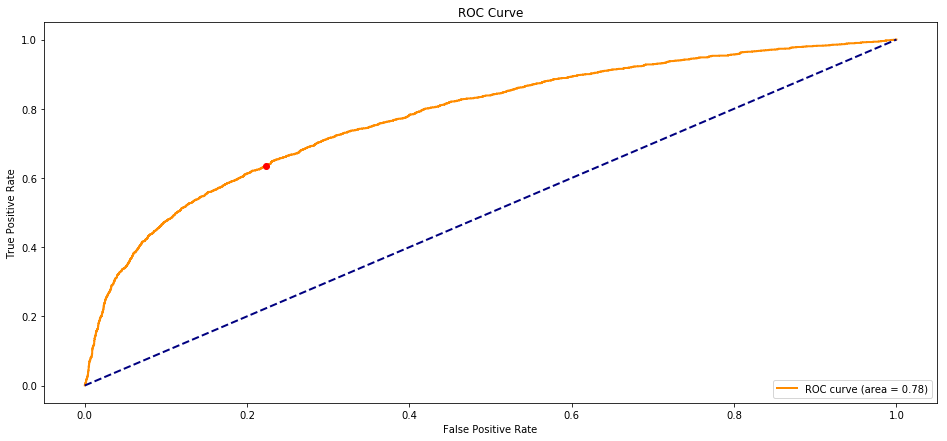

In [201]:
# parameters = {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]}
clf = LogisticRegression(penalty='l2', C=1, class_weight='balanced', fit_intercept=True, random_state=r, n_jobs=-1)
#grid_search_cv(parameters=parameters, clf=clf, scoring='f1', dataset_name='meta')
fit_and_score(clf, 'meta')
X, y, X_test, y_test = retrieve_dataset('meta')
clf.fit(X, y)
print(X_meta.columns)
print(clf.coef_)
plot_roc_curve(clf, X_test, y_test)

# Level 2 - Gaussian Naive Bayes
- f1_cv = 0.541 ± 0.021
- f1_test = 0.533

In [202]:
clf = GaussianNB()
fit_and_score(clf, 'meta')

Evaluating on meta dataset
f1_train = 0.548	 f1_cv = 0.548 ± 0.022
f1_test = 0.540
cm_train = 
[[11892  2138]
 [ 1672  2310]]
cm_test = 
[[5860 1050]
 [ 848 1114]]


(CUST_COD
 14356766    1.000000
 21308338    0.000393
 54049646    0.000029
 10396398    0.001226
 11528589    0.000056
 20362183    0.000195
 45569593    0.000533
 44429180    0.000270
 52612111    0.000289
 34291217    0.000371
 22484587    0.000343
 52913781    0.000026
 59230034    0.562689
 13175350    0.000197
 12582570    0.000106
 51594012    0.000229
 35571106    0.999999
 16001040    0.000012
 57296369    0.000412
 35902487    0.000021
 33070856    0.000932
 33183607    0.001621
 34849977    0.000010
 16490032    1.000000
 58011273    0.001273
 45734499    0.000162
 56990048    0.000025
 47504826    0.999998
 30633355    1.000000
 38597549    0.000145
               ...   
 40819584    0.000236
 26731760    0.000624
 47394107    0.000638
 46272483    0.999996
 40137864    0.000157
 57671329    0.000022
 41089924    0.000009
 19657950    0.999996
 19269106    1.000000
 36031689    0.991924
 11089246    0.994423
 17220851    0.791209
 31085210    1.000000
 36179122    0.000175


# Level 2 - Decision Tree Classifier
- f1_cv = 0.572 ± 0.020
- f1_test = 0.541

In [203]:
clf = DecisionTreeClassifier(random_state=r, max_depth=1, class_weight='balanced')
fit_and_score(clf, 'meta')

Evaluating on meta dataset
f1_train = 0.574	 f1_cv = 0.574 ± 0.020
f1_test = 0.537
cm_train = 
[[11598  2432]
 [ 1403  2579]]
cm_test = 
[[5644 1266]
 [ 776 1186]]


(CUST_COD
 14356766    0.788866
 21308338    0.298845
 54049646    0.298845
 10396398    0.788866
 11528589    0.298845
 20362183    0.298845
 45569593    0.298845
 44429180    0.298845
 52612111    0.298845
 34291217    0.298845
 22484587    0.298845
 52913781    0.298845
 59230034    0.298845
 13175350    0.298845
 12582570    0.298845
 51594012    0.298845
 35571106    0.788866
 16001040    0.298845
 57296369    0.298845
 35902487    0.298845
 33070856    0.298845
 33183607    0.788866
 34849977    0.298845
 16490032    0.788866
 58011273    0.788866
 45734499    0.298845
 56990048    0.298845
 47504826    0.788866
 30633355    0.788866
 38597549    0.298845
               ...   
 40819584    0.298845
 26731760    0.298845
 47394107    0.298845
 46272483    0.788866
 40137864    0.298845
 57671329    0.298845
 41089924    0.298845
 19657950    0.788866
 19269106    0.788866
 36031689    0.788866
 11089246    0.788866
 17220851    0.788866
 31085210    0.788866
 36179122    0.298845
